# Org the data 

In [3]:
import torch
import platform
import sys

# Check if running on macOS
if platform.system() == 'Darwin':
    # Check for MPS (Metal Performance Shaders) availability on Mac
    print(f"Running on macOS {platform.mac_ver()[0]}")
    print(f"MPS is built: {torch.backends.mps.is_built()}")
    print(f"MPS is available: {torch.backends.mps.is_available()}")
else:
    print(f"Running on {platform.system()} {platform.release()}")
    if platform.system() == 'Windows':
        # Check for CUDA availability on Windows
        print(f"CUDA is available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"CUDA version: {torch.version.cuda}")
            print(f"Number of CUDA devices: {torch.cuda.device_count()}")
            print(f"Current CUDA device: {torch.cuda.current_device()}")
            print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    else:
        print("MPS is only available on macOS devices")

Running on macOS 15.4
MPS is built: True
MPS is available: True


## Splite the RAW

In [1]:
# 
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

def extract_action_samples(csv_file, plot_stats=False):
    """
    Extract action samples from a CSV file according to specific rules.
    
    Args:
        csv_file (str): Full path to the CSV file
        plot_stats (bool): If True, plot statistics about the extracted samples
    
    Returns:
        pandas.DataFrame: Processed data with action groups and group indices
        list: Group start times
        datetime: Start time of the whole process (timestamp of first record)
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Get the start time of the whole process (first record)
    process_start_time = df['timestamp'].iloc[0] if not df.empty else None
    
    # Initialize variables
    action_groups = []
    group_start_times = []
    current_idx = 0
    all_extracted_records = []
    
    # Iterate through dataframe to find action groups
    while current_idx < len(df) - 60:  # Need at least 60 records for a complete group
        # Look for a cross button press
        if df.loc[current_idx + 10, 'button_press'] == 'cross':
            # Check if we have 10 'none' records before the press
            pre_press = df.iloc[current_idx:current_idx + 10]
            if all(pre_press['button_press'] == 'none'):
                # Extract the group: 10 records before press + 50 records starting from press
                action_group = df.iloc[current_idx:current_idx + 60]
                
                # Calculate duration
                start_time = action_group.iloc[0]['timestamp']
                end_time = action_group.iloc[-1]['timestamp']
                duration = (end_time - start_time).total_seconds()
                
                # Store group and start time
                action_groups.append({
                    'group': action_group,
                    'duration': duration
                })
                group_start_times.append(start_time)
                
                # Add group_index to records
                group_index = len(action_groups) - 1
                group_with_index = action_group.copy()
                group_with_index['group_index'] = group_index
                
                # Add to collection
                all_extracted_records.append(group_with_index)
                
                # Move to position after this group
                current_idx += 60
            else:
                # Pre-press condition not met, move forward by 1
                current_idx += 1
        else:
            # No press at expected position, move forward by 1
            current_idx += 1
    
    # Combine all extracted records
    if all_extracted_records:
        extracted_df = pd.concat(all_extracted_records)
        print(f"Extracted {len(action_groups)} action groups from {csv_file}")
        
        # Print the shape of the sample and count of how many samples
        print(f"Shape of extracted data: {extracted_df.shape}")
        print(f"Total number of samples: {len(extracted_df)}")
        print(f"Number of unique groups: {extracted_df['group_index'].nunique()}")
        
        # Print the shape of each individual sample (group)
        print("\nShape of each sample (group):")
        for i, group in enumerate(action_groups):
            group_df = group['group']
            print(f"Group {i}: {group_df.shape} - Duration: {group['duration']:.2f}s")
        
        # If plot_stats is True, visualize detailed statistics about the samples
        if plot_stats:
            # Create a figure with multiple subplots
            fig, axes = plt.subplots(len(action_groups), 3, figsize=(18, 4*len(action_groups)))
            
            # If only one group, make axes indexable
            if len(action_groups) == 1:
                axes = np.array([axes])
                
            for i, group in enumerate(action_groups):
                group_df = group['group']
                
                # Count statistics
                pre_press_count = sum(group_df.iloc[:10]['button_press'] == 'none')
                press_events = group_df.iloc[10:]['button_press'].value_counts()
                press_count = sum(group_df.iloc[10:]['button_press'] != 'none')
                post_press_none_count = sum(group_df.iloc[10:]['button_press'] == 'none')
                
                # Plot 1: Button press distribution
                press_events_df = pd.DataFrame(press_events).reset_index()
                press_events_df.columns = ['Button', 'Count']
                sns.barplot(x='Button', y='Count', data=press_events_df, ax=axes[i, 0])
                axes[i, 0].set_title(f'Group {i}: Button Press Distribution')
                axes[i, 0].set_ylabel('Count')
                axes[i, 0].tick_params(axis='x', rotation=45)
                
                # Plot 2: Gyro data over time
                time_indices = range(len(group_df))
                axes[i, 1].plot(time_indices, group_df['gyro_pitch'], label='Pitch')
                axes[i, 1].plot(time_indices, group_df['gyro_yaw'], label='Yaw')
                axes[i, 1].plot(time_indices, group_df['gyro_roll'], label='Roll')
                axes[i, 1].axvline(x=10, color='r', linestyle='--', label='First Press')
                axes[i, 1].set_title(f'Group {i}: Gyro Data')
                axes[i, 1].set_xlabel('Time Index')
                axes[i, 1].set_ylabel('Gyro Values')
                axes[i, 1].legend()
                
                # Plot 3: Accelerometer data over time
                axes[i, 2].plot(time_indices, group_df['acc_x'], label='X')
                axes[i, 2].plot(time_indices, group_df['acc_y'], label='Y')
                axes[i, 2].plot(time_indices, group_df['acc_z'], label='Z')
                axes[i, 2].axvline(x=10, color='r', linestyle='--', label='First Press')
                axes[i, 2].set_title(f'Group {i}: Accelerometer Data')
                axes[i, 2].set_xlabel('Time Index')
                axes[i, 2].set_ylabel('Accel Values')
                axes[i, 2].legend()
                
                # Add text annotation with statistics
                stats_text = (f"Duration: {group['duration']:.2f}s\n"
                             f"Pre-press none: {pre_press_count}\n"
                             f"Button presses: {press_count}\n"
                             f"Post-press none: {post_press_none_count}")
                axes[i, 0].annotate(stats_text, xy=(0.5, -0.4), xycoords='axes fraction', 
                                   ha='center', va='center', fontsize=10,
                                   bbox=dict(boxstyle='round', fc='lightyellow', alpha=0.7))
            
            plt.tight_layout()
            plt.show()
            
            # Create a summary plot
            plt.figure(figsize=(12, 8))
            
            # Plot 1: Group durations
            plt.subplot(2, 2, 1)
            durations = [group['duration'] for group in action_groups]
            plt.bar(range(len(durations)), durations)
            plt.xlabel('Group Index')
            plt.ylabel('Duration (seconds)')
            plt.title('Duration of Each Action Group')
            
            # Plot 2: Button press distribution across all groups
            plt.subplot(2, 2, 2)
            sns.countplot(x='button_press', data=extracted_df)
            plt.title('Button Press Distribution')
            plt.xlabel('Button Type')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            
            # Plot 3: Gyro data distribution
            plt.subplot(2, 2, 3)
            sns.boxplot(data=extracted_df[['gyro_pitch', 'gyro_yaw', 'gyro_roll']])
            plt.title('Gyro Data Distribution')
            plt.ylabel('Values')
            
            # Plot 4: Accelerometer data distribution
            plt.subplot(2, 2, 4)
            sns.boxplot(data=extracted_df[['acc_x', 'acc_y', 'acc_z']])
            plt.title('Accelerometer Data Distribution')
            plt.ylabel('Values')
            
            plt.tight_layout()
            plt.show()

        # Print basic information about the extracted data
        print("\nExtracted Data Overview:")
        print(f"Total records: {len(extracted_df)}")
        print(f"Number of groups: {len(action_groups)}")
        print(f"Columns: {extracted_df.columns.tolist()}")
        print("\nSample data (first 5 rows):")
        print(extracted_df.head())
        print("\nButton press distribution:")
        print(extracted_df['button_press'].value_counts())
            
        return extracted_df, group_start_times, process_start_time
    else:
        print(f"No action groups found in {csv_file}")
        return pd.DataFrame(), [], process_start_time

In [2]:
import numpy as np
import soundfile as sf
from scipy import signal
import librosa
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

def split_audio_by_timestamps(wav_file, group_start_times, process_start_time, segment_duration=0.3, 
                            half_peak_duration=0.03, plot_spectrograms=False):
    """
    Split audio file into segments based on group start times from action samples.
    
    Args:
        wav_file (str): Path to the WAV file
        group_start_times (list): List of timestamps for each group start
        process_start_time (datetime): Start time of the whole process
        segment_duration (float): Duration of each segment in seconds (default: 0.3)
        half_peak_duration (float): Half duration of peak window in seconds (default: 0.03)
        plot_spectrograms (bool): Whether to plot spectrograms (default: False)
    
    Returns:
        dict: Contains processed audio data with following keys:
            - 'audio_segments': List of raw audio segments
            - 'peak_segments': List of peak audio segments
            - 'spectrograms': List of spectrogram data
            - 'mfccs': List of MFCC features
            - 'low_power_peaks': List of indices of low power peak segments
    """
    # Load the audio file
    audio, sr = sf.read(wav_file)
    
    # Initialize storage for results
    audio_segments = []
    peak_segments = []
    spectrograms = []
    mfccs = []
    low_power_peaks = []
    off_center_peaks = []
    
    # Process each group start time
    for i, start_time in enumerate(group_start_times):
        # Calculate the start index in audio samples
        relative_seconds = (start_time - process_start_time).total_seconds()
        start_idx = int(relative_seconds * sr)
        end_idx = start_idx + int(segment_duration * sr)
        
        # Ensure indices are within bounds
        if start_idx >= 0 and end_idx <= len(audio):
            # Extract the segment
            segment = audio[start_idx:end_idx]
            audio_segments.append(segment)
            
            # Convert to mono if stereo
            if len(segment.shape) > 1 and segment.shape[1] > 1:
                segment_mono = np.mean(segment, axis=1)
            else:
                segment_mono = segment
            
            # Apply Wiener filter for denoising
            noise_samples = int(0.03 * sr)
            noise = segment_mono[:noise_samples]
            noise_psd = 0.0005 * np.mean(np.abs(np.fft.rfft(noise))**2)
            denoised_segment = signal.wiener(segment_mono, mysize=1024, noise=noise_psd)
            
            # Find peak in the middle section
            start_exclude_idx = int(0.01 * sr)
            end_exclude_idx = len(denoised_segment) - int(0.01 * sr)
            valid_segment = denoised_segment[start_exclude_idx:end_exclude_idx]
            
            # Peak detection
            abs_segment = np.abs(valid_segment)
            max_amplitude = np.max(abs_segment)
            peaks, peak_properties = signal.find_peaks(abs_segment,
                                                     prominence=0.2*max_amplitude,  # Lowered prominence threshold
                                                     distance=int(0.01*sr))
            
            # If no peaks found, use maximum value
            if len(peaks) == 0:
                peak_index = np.argmax(abs_segment) + start_exclude_idx
                peak_properties = {'prominences': [0]}
            else:
                highest_peak_idx = np.argmax(peak_properties['prominences'])
                peak_index = peaks[highest_peak_idx] + start_exclude_idx
            
            peak_time = peak_index / sr
            
            # Calculate peak window
            peak_start_time = max(0.0, peak_time - half_peak_duration)
            peak_end_time = min(segment_duration, peak_time + half_peak_duration)
            peak_start_idx = int(peak_start_time * sr)
            peak_end_idx = int(peak_end_time * sr)
            
            # Extract peak window
            peak_segment = denoised_segment[peak_start_idx:peak_end_idx]
            
            # New low power peak detection logic
            peak_absolute_value = np.abs(denoised_segment[peak_index])
            is_low_power = peak_absolute_value < 0.05  # Mark as low power if absolute peak value < 0.05
            
            if is_low_power:
                low_power_peaks.append(i)
            
            # Check if peak is centered
            window_duration = peak_end_time - peak_start_time
            middle_time = peak_start_time + window_duration / 2
            tolerance = window_duration * 0.1
            is_off_center = abs(peak_time - middle_time) > tolerance
            if is_off_center:
                off_center_peaks.append(i)
            
            # Compute spectrogram
            n_fft = 256
            hop_length = 128
            frequencies, times, Sxx = signal.spectrogram(peak_segment, sr,
                                                       nperseg=n_fft,
                                                       noverlap=n_fft-hop_length,
                                                       scaling='density')
            
            Sxx_db = 10 * np.log10(Sxx + 1e-10)
            
            # Only save the spectrogram data
            spectrograms.append(Sxx_db)
            
            # Compute MFCC
            stft = librosa.stft(peak_segment, n_fft=n_fft, hop_length=hop_length)
            mel_spec = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sr, n_mels=40)
            mfcc_features = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), 
                                               n_mfcc=13, fmax=12000, fmin=0)
            
            # Only save the MFCC data
            mfccs.append(mfcc_features)
            
            peak_segments.append(peak_segment)
    
    # Print statistics with more detail
    print(f"Processed {len(audio_segments)} segments")
    print(f"Groups with off-center peaks: {off_center_peaks}")
    print(f"Number of low power peaks (abs peak < 0.05): {len(low_power_peaks)}")
    print(f"Low power peak group indices: {low_power_peaks}")
    
    # Calculate percentage of low power peaks
    low_power_percentage = (len(low_power_peaks) / len(audio_segments)) * 100 if audio_segments else 0
    print(f"Percentage of low power peaks: {low_power_percentage:.2f}%")
    
    peak_values = [np.max(np.abs(peak_seg)) for peak_seg in peak_segments]
    print(f"\nPeak amplitude statistics:")
    print(f"Min peak amplitude: {min(peak_values):.3f}")
    print(f"Max peak amplitude: {max(peak_values):.3f}")
    print(f"Mean peak amplitude: {np.mean(peak_values):.3f}")
    
    # Print sample shapes
    if spectrograms and mfccs:
        print(f"\nSample spectrogram shape frequency bins , number of time slices: {spectrograms[0].shape[0]} , {spectrograms[0].shape[1 ]}")
        print(f"Sample MFCC shape number of mfcc coefficients , number of time slices: {mfccs[0].shape[0]} , {mfccs[0].shape[1 ]}")
        print('\n')
    
    if plot_spectrograms and spectrograms:
        # Plot configuration
        num_specs = len(spectrograms)
        cols = 10
        rows = (num_specs + cols - 1) // cols
        
        fig = plt.figure(figsize=(20, 2 * rows))
        gs = GridSpec(rows, cols, figure=fig)
        
        for i in range(len(spectrograms)):
            row = i // cols
            col = i % cols
            
            ax = fig.add_subplot(gs[row, col])
            denoised_segment_to_plot = audio_segments[i]
            if len(denoised_segment_to_plot.shape) > 1:
                denoised_segment_to_plot = np.mean(denoised_segment_to_plot, axis=1)
            
            time_axis = np.linspace(0, segment_duration, len(denoised_segment_to_plot))
            ax.plot(time_axis, denoised_segment_to_plot)
            
            # Simplified title
            title_color = 'red' if i in low_power_peaks else 'black'
            ax.set_title(f'Group {i}', color=title_color)
            
            if row < rows - 1:
                ax.set_xlabel('')
            if col > 0:
                ax.set_ylabel('')
            else:
                ax.set_ylabel('Amplitude')
        
        plt.suptitle('Denoised audio segments (Y-axis: normalized amplitude [-1, 1])', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
    
    return {
        'audio_segments': audio_segments,
        'peak_segments': peak_segments,
        'spectrograms': spectrograms,
        'mfccs': mfccs,
        'low_power_peaks': low_power_peaks
    }

In [4]:
### read the data 

user1_offh_csv="../data/fuse_one/controller_data_user1_non-haptic_20250328_181856.csv"
user2_offh_csv="../data/fuse_one/controller_data_user2_non-haptic_20250327_152659.csv"
user3_offh_csv='../data/fuse_one/controller_data_user3_non-haptic_20250327_160855.csv'
user4_offh_csv='../data/fuse_one/controller_data_user4_non-haptic_20250327_165510.csv'

user1_offh_wav="../data/fuse_one/audio_user1_non-haptic_20250328_181856.wav"
user2_offh_wav="../data/fuse_one/audio_user2_non-haptic_20250327_152659.wav"
user3_offh_wav='../data/fuse_one/audio_user3_non-haptic_20250327_160855.wav'
user4_offh_wav='../data/fuse_one/audio_user4_non-haptic_20250327_165510.wav'

In [5]:
u1_df,u1_g_time,u1_pro_time= extract_action_samples(user1_offh_csv)
u2_df,u2_g_time,u2_pro_time=extract_action_samples(user2_offh_csv)
u3_df,u3_g_time,u3_pro_time=extract_action_samples(user3_offh_csv)
u4_df,u4_g_time,u4_pro_time=extract_action_samples(user4_offh_csv)

Extracted 126 action groups from ../data/fuse_one/controller_data_user1_non-haptic_20250328_181856.csv
Shape of extracted data: (7560, 11)
Total number of samples: 7560
Number of unique groups: 126

Shape of each sample (group):
Group 0: (60, 10) - Duration: 0.29s
Group 1: (60, 10) - Duration: 0.30s
Group 2: (60, 10) - Duration: 0.30s
Group 3: (60, 10) - Duration: 0.29s
Group 4: (60, 10) - Duration: 0.30s
Group 5: (60, 10) - Duration: 0.30s
Group 6: (60, 10) - Duration: 0.30s
Group 7: (60, 10) - Duration: 0.30s
Group 8: (60, 10) - Duration: 0.29s
Group 9: (60, 10) - Duration: 0.30s
Group 10: (60, 10) - Duration: 0.30s
Group 11: (60, 10) - Duration: 0.30s
Group 12: (60, 10) - Duration: 0.30s
Group 13: (60, 10) - Duration: 0.30s
Group 14: (60, 10) - Duration: 0.30s
Group 15: (60, 10) - Duration: 0.29s
Group 16: (60, 10) - Duration: 0.30s
Group 17: (60, 10) - Duration: 0.29s
Group 18: (60, 10) - Duration: 0.29s
Group 19: (60, 10) - Duration: 0.29s
Group 20: (60, 10) - Duration: 0.30s
Grou

In [6]:
u1_audio_splited=split_audio_by_timestamps(user1_offh_wav,u1_g_time,u1_pro_time,plot_spectrograms=False)
u2_audio_splited=split_audio_by_timestamps(user2_offh_wav,u2_g_time,u2_pro_time,plot_spectrograms=False)
u3_audio_splited=split_audio_by_timestamps(user3_offh_wav,u3_g_time,u3_pro_time,plot_spectrograms=False)
u4_audio_splited=split_audio_by_timestamps(user4_offh_wav,u4_g_time,u4_pro_time,plot_spectrograms=False)

Processed 126 segments
Groups with off-center peaks: [47, 49, 95, 117, 123]
Number of low power peaks (abs peak < 0.05): 64
Low power peak group indices: [0, 1, 3, 5, 10, 11, 13, 14, 17, 19, 21, 24, 27, 32, 34, 35, 37, 40, 42, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 58, 61, 71, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 94, 95, 96, 98, 99, 102, 106, 107, 108, 109, 110, 115, 116, 117, 121, 122, 123, 124, 125]
Percentage of low power peaks: 50.79%

Peak amplitude statistics:
Min peak amplitude: 0.003
Max peak amplitude: 0.475
Mean peak amplitude: 0.089

Sample spectrogram shape frequency bins , number of time slices: 129 , 21
Sample MFCC shape number of mfcc coefficients , number of time slices: 13 , 23


Processed 98 segments
Groups with off-center peaks: [49]
Number of low power peaks (abs peak < 0.05): 98
Low power peak group indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

In [7]:
### prepare the data 
def calculate_derivative_rms_features(data, window_size=5):
    """
    Calculate RMS features for derivatives using sliding windows
    Args:
        data: numpy array of shape (N, 6) - sequence with 6 features
        window_size: size of window for RMS calculation (default=5)
    Returns:
        numpy array of RMS values for each complete window
    """
    n_windows = len(data) // window_size
    if len(data) % window_size > 0:  # Handle remaining data
        n_windows += 1
    
    rms_features = []
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = min(start_idx + window_size, len(data))
        window_data = data[start_idx:end_idx, :]
        
        # Calculate RMS for each feature in this window
        rms = np.sqrt(np.mean(np.square(window_data), axis=0))
        rms_features.append(rms)
    
    return np.array(rms_features)  # Shape: (n_windows, 6)

def prepare_derivative_features(data):
    """
    Calculate first and second derivatives and their RMS features
    Args:
        data: numpy array of shape (60, 6) - one sample/sequence with 6 features
    Returns:
        combined RMS features from both derivatives
        shape: (12, 12) - 12 time steps, 12 features (6 from each derivative)
    """
    # Apply z-score normalization to the entire sequence first
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0) + 1e-9
    normalized_data = (data - mean) / std
    
    # Calculate first derivative from normalized data
    first_derivative = np.diff(normalized_data, axis=0)  # Shape: (59, 6)
    
    # Calculate second derivative
    second_derivative = np.diff(first_derivative, axis=0)  # Shape: (58, 6)
    
    # Calculate RMS features for both derivatives
    first_der_rms = calculate_derivative_rms_features(first_derivative)  # Shape: (~12, 6)
    second_der_rms = calculate_derivative_rms_features(second_derivative)  # Shape: (~12, 6)
    
    # Ensure both have exactly 12 windows by padding or truncating
    target_length = 12
    
    def adjust_length(features, target_len):
        if len(features) > target_len:
            return features[:target_len]
        elif len(features) < target_len:
            padding = np.zeros((target_len - len(features), features.shape[1]))
            return np.vstack([features, padding])
        return features
    
    first_der_rms = adjust_length(first_der_rms, target_length)
    second_der_rms = adjust_length(second_der_rms, target_length)
    
    # Combine features
    combined_features = np.hstack([first_der_rms, second_der_rms])  # Shape: (12, 12)
    
    return combined_features


## Data manger

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from collections import Counter
import pandas as pd

@dataclass
class UserData:
    """Data class to store user-specific data components"""
    df: pd.DataFrame
    audio_splited: Dict[str, List]
    meg_data: Optional[Dict] = None

class PlaySenseDataManager:
    """
    A comprehensive data manager for PlaySense data that handles:
    1. Data merging from different sources
    2. Dataset creation for PyTorch
    3. Data splitting and loader creation
    """
    def __init__(self):
        self.users_data = {}
        self.merged_data = {}
        self.dataset = None
    
    def add_user_data(self, user_id: int, user_data: UserData) -> None:
        """Add data for a specific user"""
        self.users_data[user_id] = user_data
        
    def merge_all_users_data(self) -> None:
        """Merge data for all added users"""
        for user_id, user_data in self.users_data.items():
            merged = self._merge_action_and_audio_data(
                df=user_data.df,
                audio_samples=user_data.audio_splited['audio_segments'],
                peak_samples=user_data.audio_splited['peak_segments'],
                spec_samples=user_data.audio_splited['spectrograms'],
                mfcc_samples=user_data.audio_splited['mfccs'],
                low_power_peaks=user_data.audio_splited['low_power_peaks']
            )
            self.merged_data[user_id] = merged
            print(f"\nUser {user_id} data merged successfully:")
            print(f"Number of groups: {len(merged)}")
            
            if merged:
                first_group_idx = list(merged.keys())[0]
                first_group = merged[first_group_idx]
                
                derivative_rms = first_group['action_data']['inertial_features']['derivative_rms']
                if derivative_rms is None:
                    print(f"ERROR: derivative_rms is None for user {user_id}, group {first_group_idx}")
                    continue
                
                inertial_shape = derivative_rms.shape
                
                mfcc = first_group['audio_data']['mfcc']
                if mfcc is None:
                    print(f"ERROR: mfcc is None for user {user_id}, group {first_group_idx}")
                    continue
                
                mfcc_shape = mfcc.shape
                
                print(f"Example shapes from first group (group {first_group_idx}):")
                print(f"  - Inertial features shape: {inertial_shape}")
                print(f"  - MFCC features shape: {mfcc_shape}")

    def _merge_action_and_audio_data(self, df, audio_samples, peak_samples, 
                                   spec_samples, mfcc_samples, low_power_peaks):
        """Internal method for merging action and audio data"""
        # Verify input sample counts
        group_indices = df['group_index'].unique()
        n_groups = len(group_indices)
        
        # Initialize the merged dataset
        merged_data = {}
        
        # Inertial data columns to extract
        inertial_columns = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 
                           'acc_x', 'acc_y', 'acc_z']
        
        # Process each group
        for group_idx in group_indices:
            if int(group_idx) in low_power_peaks:
                continue
                
            group_df = df[df['group_index'] == group_idx].copy()
            inertial_data = group_df[inertial_columns].values
            
            # Check if inertial_data is valid
            if inertial_data.size == 0:
                print(f"WARNING: Empty inertial data for group {group_idx}, skipping")
                continue
                
            derivative_features = self._prepare_derivative_features(inertial_data)
            
            if derivative_features is None:
                print(f"ERROR: _prepare_derivative_features returned None for group {group_idx}")
                continue
                
            # Check if audio data exists for this group
            group_idx_int = int(group_idx)
            audio_idx = np.where(np.array([i == group_idx_int for i in range(len(audio_samples))]))[0]
            mfcc_idx = np.where(np.array([i == group_idx_int for i in range(len(mfcc_samples))]))[0]
            
            if len(audio_idx) == 0:
                print(f"WARNING: No audio data for group {group_idx}, skipping")
                continue
                
            if len(mfcc_idx) == 0:
                print(f"WARNING: No MFCC data for group {group_idx}, skipping")
                continue
            
            merged_data[int(group_idx)] = {
                'action_data': {
                    'dataframe': group_df,
                    'inertial_features': {
                        'derivative_rms': derivative_features,
                        'feature_names': {
                            'first_derivative': [f'first_der_rms_{col}' for col in inertial_columns],
                            'second_derivative': [f'second_der_rms_{col}' for col in inertial_columns]
                        }
                    }
                },
                'audio_data': {
                    'raw_audio': audio_samples[audio_idx[0]],
                    'peak_audio': peak_samples[audio_idx[0]],
                    'spectrogram': spec_samples[audio_idx[0]],
                    'mfcc': mfcc_samples[mfcc_idx[0]],
                    'is_low_power': False
                }
            }
        
        return merged_data

    def _prepare_derivative_features(self, inertial_data):
        """Prepare derivative features from inertial data"""
        try:
            return prepare_derivative_features(inertial_data)
        except Exception as e:
            print(f"ERROR in _prepare_derivative_features: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def create_dataset(self) -> None:
        """Create PyTorch dataset from merged data"""
        self.dataset = PlaySenseDataset(
            data_dict=self.merged_data
        )

    def create_data_loaders(self, 
                          batch_size: int = 32,
                          train_ratio: float = 0.8,
                          shuffle: bool = True) -> Tuple[DataLoader, DataLoader]:
        """Create train and validation data loaders"""
        if self.dataset is None:
            raise ValueError("Dataset not created. Call create_dataset() first.")

        # Calculate split sizes
        train_size = int(train_ratio * len(self.dataset))
        val_size = len(self.dataset) - train_size

        # Split dataset
        train_dataset, val_dataset = torch.utils.data.random_split(
            self.dataset, 
            [train_size, val_size]
        )

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        return train_loader, val_loader
    
class PlaySenseDataset(Dataset):
    """PyTorch Dataset for PlaySense data"""
    def __init__(self, data_dict: Dict):
        self.inertial_features = []
        self.mfcc_features = []
        self.labels = []
        
        print("\nInitializing Dataset:")
        print(f"Number of users: {len(data_dict)}")
        
        # Create label mapping (user_id -> consecutive index)
        unique_user_ids = sorted(list(data_dict.keys()))
        self.label_mapping = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
        self.inverse_mapping = {idx: user_id for user_id, idx in self.label_mapping.items()}
        
        print("\nLabel mapping (user_id -> model_label):")
        for user_id, idx in self.label_mapping.items():
            print(f"User {user_id} -> Label {idx}")
        
        # Track samples statistics
        samples_stats = {user_id: {'kept': 0, 'discarded': 0} for user_id in data_dict.keys()}
        discarded_groups = {user_id: [] for user_id in data_dict.keys()}
        
        for user_id, user_data in data_dict.items():
            if user_data is None or len(user_data) == 0:
                print(f"Warning: Empty or None data for user {user_id}")
                continue
            
            for group_idx in user_data:
                group = user_data[group_idx]
                
                try:
                    # Get MFCC features and check shape
                    mfcc = group['audio_data']['mfcc']
                    
                    # Only keep samples with shape (13, 23)
                    if not isinstance(mfcc, np.ndarray) or mfcc.shape != (13, 23):
                        samples_stats[user_id]['discarded'] += 1
                        discarded_groups[user_id].append(group_idx)
                        continue
                    
                    # Get inertial features
                    inertial = group['action_data']['inertial_features']['derivative_rms']
                    
                    # Verify inertial feature type
                    if not isinstance(inertial, np.ndarray):
                        print(f"Warning: Invalid inertial feature type for user {user_id}, group {group_idx}")
                        continue
                    
                    self.inertial_features.append(inertial)
                    self.mfcc_features.append(mfcc)
                    # Map user_id to consecutive index
                    self.labels.append(self.label_mapping[user_id])
                    samples_stats[user_id]['kept'] += 1
                    
                except KeyError as e:
                    print(f"Warning: Missing data structure for user {user_id}, group {group_idx}: {e}")
                except Exception as e:
                    print(f"Error processing user {user_id}, group {group_idx}: {e}")
        
        # Print detailed statistics
        print("\nSampling Statistics:")
        print("-------------------")
        for user_id in samples_stats:
            stats = samples_stats[user_id]
            print(f"\nUser {user_id} (Label {self.label_mapping[user_id]}):")
            print(f"  Kept samples: {stats['kept']}")
            print(f"  Discarded samples: {stats['discarded']}")
            if discarded_groups[user_id]:
                print(f"  Discarded group indices: {discarded_groups[user_id]}")
        
        # Convert to tensors if we have data
        if self.inertial_features and self.mfcc_features:
            try:
                self.inertial_features = torch.FloatTensor(np.array(self.inertial_features))
                self.mfcc_features = torch.FloatTensor(np.array(self.mfcc_features))
                self.labels = torch.LongTensor(self.labels)
                
                # Print final dataset statistics
                print("\nFinal Dataset Statistics:")
                print("------------------------")
                print(f"Total samples: {len(self.labels)}")
                class_dist = Counter(self.labels.numpy())
                print("\nClass distribution:")
                for label, count in sorted(class_dist.items()):
                    original_id = self.inverse_mapping[label]
                    print(f"User {original_id} (Label {label}): {count} samples")
                print(f"\nFeature shapes:")
                print(f"Inertial features: {self.inertial_features.shape}")
                print(f"MFCC features: {self.mfcc_features.shape}")
                
                # Verify label range
                min_label = self.labels.min().item()
                max_label = self.labels.max().item()
                num_classes = len(self.label_mapping)
                print(f"\nLabel range: [{min_label}, {max_label}] (Number of classes: {num_classes})")
                
            except Exception as e:
                print(f"Error converting to tensors: {e}")
                raise
        else:
            raise ValueError("No valid samples found in the dataset")
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'inertial': self.inertial_features[idx],
            'mfcc': self.mfcc_features[idx],
            'label': self.labels[idx]
        }
    
    def get_num_classes(self):
        """Return the number of classes in the dataset"""
        return len(self.label_mapping)
    
    def get_unique_classes(self):
        """Return the list of unique class labels in the dataset"""
        return sorted(list(self.label_mapping.values()))

# Model


In [9]:
import torch
import torch.nn as nn

#  multi classes model 
class InertialMFCCTransformer(nn.Module):
    def __init__(self, 
                 inertial_dim=12,      # Inertial features dimension (12 for your 12x12 data)
                 mfcc_dim=13,          # MFCC features dimension (13 for your 13x23 data)
                 num_classes=3,         # Number of output classes
                 d_model=64,           # Hidden dimension
                 nhead=4,              # Number of attention heads
                 num_layers=2,         # Number of transformer layers
                 dropout=0.1):         # Dropout rate
        super().__init__()
        
        # 1. Inertial Branch
        # Convert inertial features to transformer dimension
        self.inertial_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Inertial transformer encoder
        self.inertial_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 2. MFCC Branch
        # Convert MFCC features to transformer dimension
        self.mfcc_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # MFCC transformer encoder
        self.mfcc_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 3. Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, inertial_data, mfcc_data):
        """
        Forward pass of the model.
        Args:
            inertial_data: tensor of shape (batch_size, 12, 12)
            mfcc_data: tensor of shape (batch_size, 13, 23)
        Returns:
            output: tensor of shape (batch_size, num_classes)
        """
        # 1. Process Inertial Data
        # Transform and encode inertial features
        x_inertial = self.inertial_embedding(inertial_data)     # (batch_size, 12, d_model)
        x_inertial = self.inertial_transformer(x_inertial)      # (batch_size, 12, d_model)
        # Global average pooling
        x_inertial = torch.mean(x_inertial, dim=1)             # (batch_size, d_model)
        
        # 2. Process MFCC Data
        # Transpose MFCC data to handle time dimension
        x_mfcc = self.mfcc_embedding(mfcc_data.transpose(1, 2)) # (batch_size, 23, d_model)
        x_mfcc = self.mfcc_transformer(x_mfcc)                  # (batch_size, 23, d_model)
        # Global average pooling
        x_mfcc = torch.mean(x_mfcc, dim=1)                     # (batch_size, d_model)
        
        # 3. Mid-Fusion
        # Concatenate features from both modalities
        x_combined = torch.cat([x_inertial, x_mfcc], dim=1)    # (batch_size, d_model*2)
        x_fused = self.fusion(x_combined)                      # (batch_size, d_model)
        
        # 4. Classification
        output = self.classifier(x_fused)                      # (batch_size, num_classes)
        
        return output

# Binary classifier model
class BinaryInertialMFCCTransformer(nn.Module):
    def __init__(self, 
                 inertial_dim=12,      # Inertial features dimension (12 for your 12x12 data)
                 mfcc_dim=13,          # MFCC features dimension (13 for your 13x23 data)
                 d_model=64,           # Hidden dimension
                 nhead=4,              # Number of attention heads
                 num_layers=2,         # Number of transformer layers
                 dropout=0.1):         # Dropout rate
        super().__init__()
        
        # 1. Inertial Branch
        # Convert inertial features to transformer dimension
        self.inertial_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Inertial transformer encoder
        self.inertial_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 2. MFCC Branch
        # Convert MFCC features to transformer dimension
        self.mfcc_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # MFCC transformer encoder
        self.mfcc_transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        # 3. Fusion Layer
        self.fusion = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # 4. Binary Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )
        
    def forward(self, inertial_data, mfcc_data):
        """
        Forward pass of the binary classification model.
        Args:
            inertial_data: tensor of shape (batch_size, 12, 12)
            mfcc_data: tensor of shape (batch_size, 13, 23)
        Returns:
            output: tensor of shape (batch_size, 1) with values between 0 and 1
        """
        # 1. Process Inertial Data
        # Transform and encode inertial features
        x_inertial = self.inertial_embedding(inertial_data)     # (batch_size, 12, d_model)
        x_inertial = self.inertial_transformer(x_inertial)      # (batch_size, 12, d_model)
        # Global average pooling
        x_inertial = torch.mean(x_inertial, dim=1)             # (batch_size, d_model)
        
        # 2. Process MFCC Data
        # Transpose MFCC data to handle time dimension
        x_mfcc = self.mfcc_embedding(mfcc_data.transpose(1, 2)) # (batch_size, 23, d_model)
        x_mfcc = self.mfcc_transformer(x_mfcc)                  # (batch_size, 23, d_model)
        # Global average pooling
        x_mfcc = torch.mean(x_mfcc, dim=1)                     # (batch_size, d_model)
        
        # 3. Mid-Fusion
        # Concatenate features from both modalities
        x_combined = torch.cat([x_inertial, x_mfcc], dim=1)    # (batch_size, d_model*2)
        x_fused = self.fusion(x_combined)                      # (batch_size, d_model)
        
        # 4. Binary Classification
        output = self.classifier(x_fused)                      # (batch_size, 1)
        
        return output



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class InertialMFCCTransformerAutoencoder(nn.Module):
    def __init__(self,
                 inertial_dim=12,
                 mfcc_dim=13,
                 d_model=64,
                 nhead=4,
                 num_layers=2,
                 dropout=0.1,
                 max_seq_len=100):
        super().__init__()

        # Positional encodings
        self.inertial_pos_enc = PositionalEncoding(d_model, max_seq_len)
        self.mfcc_pos_enc = PositionalEncoding(d_model, max_seq_len)

        # Encoder embeddings
        self.inertial_encoder_embedding = nn.Sequential(
            nn.Linear(inertial_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.mfcc_encoder_embedding = nn.Sequential(
            nn.Linear(mfcc_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Transformer encoders
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.inertial_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mfcc_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Fusion (per time step)
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Decoders (reconstruct sequences)
        self.inertial_decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, inertial_dim)
        )

        self.mfcc_decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, mfcc_dim)
        )

    def forward(self, inertial_data, mfcc_data):
        # Encode Inertial
        inertial_embed = self.inertial_encoder_embedding(inertial_data)
        inertial_embed = self.inertial_pos_enc(inertial_embed)
        inertial_encoded = self.inertial_encoder(inertial_embed)

        # Encode MFCC
        mfcc_input = mfcc_data.transpose(1, 2)  # (B, T, mfcc_dim)
        mfcc_embed = self.mfcc_encoder_embedding(mfcc_input)
        mfcc_embed = self.mfcc_pos_enc(mfcc_embed)
        mfcc_encoded = self.mfcc_encoder(mfcc_embed)

        # ⚠️ Resize inertial to match MFCC sequence length
        if inertial_encoded.shape[1] != mfcc_encoded.shape[1]:
            inertial_encoded = torch.nn.functional.interpolate(
                inertial_encoded.transpose(1, 2),  # (B, D, T)
                size=mfcc_encoded.shape[1],        # Match MFCC T
                mode='linear',
                align_corners=False
            ).transpose(1, 2)  # Back to (B, T, D)

        # Fuse encodings
        fused = torch.cat([inertial_encoded, mfcc_encoded], dim=-1)
        fused = self.fusion_layer(fused)

        # Decode
        inertial_reconstructed = self.inertial_decoder(fused)  # (B, T, inertial_dim)
        mfcc_reconstructed = self.mfcc_decoder(fused)          # (B, T, mfcc_dim)

        # Transpose MFCC back to (B, mfcc_dim, T)
        return inertial_reconstructed, mfcc_reconstructed.transpose(1, 2)



# Train 

In [10]:


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np
from datetime import datetime
import os
from collections import Counter
import matplotlib.pyplot as plt

class PlaySenseTrainerV2:


    def __init__(
        self,
        model,
        data_manager,
        mode='multiclass',  # 'multiclass', 'binary', or 'autoencoder'
        learning_rate=0.001,
        num_epochs=50,
        device=None,
        checkpoint_dir='checkpoints'
    ):
        self.mode = mode
        self.data_manager = data_manager
        self.num_epochs = num_epochs
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoint_dir = checkpoint_dir
        
        # Create checkpoint directory
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        if mode == 'multiclass':
            # Existing multiclass initialization
            self.model = model.to(self.device)
            self.criterion = nn.CrossEntropyLoss()
            self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
            
        elif mode == 'binary':
            # Existing binary initialization
            self.unique_classes = sorted(list(self.data_manager.dataset.label_mapping.values()))
            self.models = {}
            self.optimizers = {}
            self.criterion = nn.BCELoss()
            
            for class_idx in self.unique_classes:
                self.models[class_idx] = model().to(self.device)
                self.optimizers[class_idx] = optim.Adam(self.models[class_idx].parameters(), lr=learning_rate)
                
        elif mode == 'autoencoder':
            # New autoencoder initialization
            self.unique_classes = sorted(list(self.data_manager.dataset.label_mapping.values()))
            self.models = {}
            self.optimizers = {}
            self.criterion = nn.MSELoss()  # Use MSE loss for reconstruction
            
            for class_idx in self.unique_classes:
                self.models[class_idx] = model().to(self.device)
                self.optimizers[class_idx] = optim.Adam(self.models[class_idx].parameters(), lr=learning_rate)
        else:
            raise ValueError(f"Invalid mode: {mode}. Must be 'multiclass', 'binary', or 'autoencoder'")
        
        # Initialize best metrics
        self.best_val_metrics = self._initialize_best_metrics()
        
        # Metrics history
        self.history = self._initialize_history()

    def _initialize_best_metrics(self):
        """Initialize best metrics based on mode"""
        if self.mode == 'multiclass':
            return {'accuracy': 0.0}
        elif self.mode == 'binary':
            return {class_idx: {'auc': 0.0} for class_idx in self.unique_classes}
        else:  # autoencoder mode
            return {class_idx: {'accuracy': 0.0} for class_idx in self.unique_classes}

    def _initialize_history(self):
        """Initialize metrics history based on mode"""
        if self.mode == 'multiclass':
            return {
                'train_loss': [], 'train_acc': [], 'train_f1': [],
                'val_loss': [], 'val_acc': [], 'val_f1': []
            }
        elif self.mode == 'binary':
            history = {}
            for class_idx in self.unique_classes:
                history[class_idx] = {
                    'train_loss': [], 'train_auc': [], 'train_f1': [],
                    'val_loss': [], 'val_auc': [], 'val_f1': []
                }
            return history
        else:  # autoencoder mode
            history = {}
            for class_idx in self.unique_classes:
                history[class_idx] = {
                    'train_loss': [], 'train_accuracy': [], 'train_far': [], 
                    'train_frr': [], 'train_eer': [],
                    'val_loss': [], 'val_accuracy': [], 'val_far': [], 
                    'val_frr': [], 'val_eer': []
                }
            return history

    def _prepare_binary_labels(self, labels, target_class):
        """Convert multiclass labels to binary labels for one-vs-all"""
        return (labels == target_class).float()

    def train(self, batch_size=32, train_ratio=0.8):
        """Main training loop"""
        print(f"Starting training in {self.mode} mode on device: {self.device}")
        
        # Create data loaders
        train_loader, val_loader = self.data_manager.create_data_loaders(
            batch_size=batch_size,
            train_ratio=train_ratio
        )
        
        # Print dataset distribution
        self._print_dataset_distribution(train_loader, val_loader)
        
        if self.mode == 'multiclass':
            self._train_multiclass(train_loader, val_loader)
        elif self.mode == 'binary':
            self._train_binary(train_loader, val_loader)
        else:  # autoencoder mode
            self._train_autoencoder(train_loader, val_loader)

    def _train_multiclass(self, train_loader, val_loader):
        """Training loop for multiclass classification"""
        for epoch in range(self.num_epochs):
            # Training phase
            train_metrics = self._train_epoch_multiclass(train_loader)
            
            # Validation phase
            val_metrics = self._validate_multiclass(val_loader)
            
            # Update history
            self._update_history_multiclass(train_metrics, val_metrics)
            
            # Print metrics
            self._print_metrics_multiclass(epoch, train_metrics, val_metrics)
            
            # Save checkpoint if best model
            if val_metrics['accuracy'] > self.best_val_metrics['accuracy']:
                self.best_val_metrics['accuracy'] = val_metrics['accuracy']
                self._save_checkpoint_multiclass(epoch, val_metrics)

    def _train_binary(self, train_loader, val_loader):
        """Training loop for binary classification (one-vs-all)"""
        # Initialize dictionaries to store best metrics for each class
        final_best_metrics = {class_idx: {'auc': 0.0, 'f1': 0.0, 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0} 
                            for class_idx in self.unique_classes}
        
        for class_idx in self.unique_classes:
            print(f"\nTraining binary classifier for class {class_idx}")
            model = self.models[class_idx]
            optimizer = self.optimizers[class_idx]
            
            best_val_metrics = None
            
            for epoch in range(self.num_epochs):
                # Training phase
                train_metrics = self._train_epoch_binary(train_loader, model, optimizer, class_idx)
                
                # Validation phase
                val_metrics = self._validate_binary(val_loader, model, class_idx)
                
                # Update history
                self._update_history_binary(train_metrics, val_metrics, class_idx)
                
                # Print metrics
                self._print_metrics_binary(epoch, train_metrics, val_metrics, class_idx)
                
                # Save checkpoint and update best metrics if best model
                if val_metrics['auc'] > self.best_val_metrics[class_idx]['auc']:
                    self.best_val_metrics[class_idx]['auc'] = val_metrics['auc']
                    best_val_metrics = val_metrics
                    self._save_checkpoint_binary(epoch, val_metrics, class_idx)
            
            # Store best metrics for this class
            if best_val_metrics:
                final_best_metrics[class_idx] = best_val_metrics
        
        # Calculate and print average metrics across all binary classifiers
        self._print_average_binary_metrics(final_best_metrics)

    def _train_epoch_multiclass(self, train_loader):
        """Train for one epoch in multiclass mode"""
        self.model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []
        
        for batch in train_loader:
            inertial = batch['inertial'].to(self.device)
            mfcc = batch['mfcc'].to(self.device)
            labels = batch['label'].to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(inertial, mfcc)
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        
        return self._calculate_metrics_multiclass(predictions, true_labels, running_loss, len(train_loader))
    

    def _print_average_binary_metrics(self, final_best_metrics):
        """Print average metrics across all binary classifiers"""
        # Initialize metric sums
        metric_sums = {
            'auc': 0.0,
            'accuracy': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0
        }
        
        # Sum up metrics from all classifiers
        for class_metrics in final_best_metrics.values():
            for metric in metric_sums:
                metric_sums[metric] += class_metrics[metric]
        
        # Calculate averages
        num_classes = len(self.unique_classes)
        avg_metrics = {metric: value / num_classes for metric, value in metric_sums.items()}
        
        # Print detailed results
        print("\n" + "="*50)
        print("FINAL BINARY CLASSIFICATION RESULTS")
        print("="*50)
        
        # Print individual class results
        print("\nBest metrics for each class:")
        for class_idx, metrics in final_best_metrics.items():
            print(f"\nClass {class_idx}:")
            print(f"  AUC: {metrics['auc']:.4f}")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Score: {metrics['f1']:.4f}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
        
        # Print average results
        print("\nAVERAGE METRICS ACROSS ALL CLASSES:")
        print(f"  Average AUC: {avg_metrics['auc']:.4f}")
        print(f"  Average Accuracy: {avg_metrics['accuracy']:.4f}")
        print(f"  Average F1-Score: {avg_metrics['f1']:.4f}")
        print(f"  Average Precision: {avg_metrics['precision']:.4f}")
        print(f"  Average Recall: {avg_metrics['recall']:.4f}")
        print("\n" + "="*50)
        
        # Store average metrics in history
        self.history['average_metrics'] = avg_metrics

    def _train_epoch_binary(self, train_loader, model, optimizer, target_class):
        """Train for one epoch in binary mode"""
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []
        
        for batch in train_loader:
            inertial = batch['inertial'].to(self.device)
            mfcc = batch['mfcc'].to(self.device)
            labels = self._prepare_binary_labels(batch['label'], target_class).to(self.device)
            
            optimizer.zero_grad()
            outputs = model(inertial, mfcc)
            loss = self.criterion(outputs.squeeze(), labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        
        return self._calculate_metrics_binary(predictions, true_labels, running_loss, len(train_loader))

    def _validate_multiclass(self, val_loader):
        """Validate in multiclass mode"""
        self.model.eval()
        running_loss = 0.0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inertial = batch['inertial'].to(self.device)
                mfcc = batch['mfcc'].to(self.device)
                labels = batch['label'].to(self.device)
                
                outputs = self.model(inertial, mfcc)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predictions.extend(outputs.argmax(dim=1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        return self._calculate_metrics_multiclass(predictions, true_labels, running_loss, len(val_loader))

    def _validate_binary(self, val_loader, model, target_class):
        """Validate in binary mode"""
        model.eval()
        running_loss = 0.0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inertial = batch['inertial'].to(self.device)
                mfcc = batch['mfcc'].to(self.device)
                labels = self._prepare_binary_labels(batch['label'], target_class).to(self.device)
                
                outputs = model(inertial, mfcc)
                loss = self.criterion(outputs.squeeze(), labels)
                
                running_loss += loss.item()
                predictions.extend(outputs.squeeze().cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        return self._calculate_metrics_binary(predictions, true_labels, running_loss, len(val_loader))

    def plot_training_history(self):
        """Plot training history based on mode"""
        if self.mode == 'multiclass':
            self._plot_multiclass_history()
        elif self.mode == 'binary':
            self._plot_binary_history()
            self._plot_average_binary_metrics()
        else:  # autoencoder mode
            self._plot_autoencoder_history()

    def _plot_multiclass_history(self):
        """Plot training history for multiclass mode"""
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Training Accuracy')
        plt.plot(self.history['val_acc'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def _plot_binary_history(self):
        """Plot training history for binary mode"""
        num_classes = len(self.unique_classes)
        fig, axes = plt.subplots(num_classes, 2, figsize=(15, 5*num_classes))
        
        for idx, class_idx in enumerate(self.unique_classes):
            # Plot loss
            axes[idx, 0].plot(self.history[class_idx]['train_loss'], label='Training Loss')
            axes[idx, 0].plot(self.history[class_idx]['val_loss'], label='Validation Loss')
            axes[idx, 0].set_xlabel('Epoch')
            axes[idx, 0].set_ylabel('Loss')
            axes[idx, 0].set_title(f'Class {class_idx} - Loss')
            axes[idx, 0].legend()
            axes[idx, 0].grid(True)
            
            # Plot AUC
            axes[idx, 1].plot(self.history[class_idx]['train_auc'], label='Training AUC')
            axes[idx, 1].plot(self.history[class_idx]['val_auc'], label='Validation AUC')
            axes[idx, 1].set_xlabel('Epoch')
            axes[idx, 1].set_ylabel('AUC')
            axes[idx, 1].set_title(f'Class {class_idx} - AUC')
            axes[idx, 1].legend()
            axes[idx, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

    def _plot_average_binary_metrics(self):
        """Plot average metrics comparison across classes"""
        metrics = ['auc', 'accuracy', 'f1', 'precision', 'recall']
        class_indices = list(self.unique_classes)
        
        # Prepare data for plotting
        metric_values = {metric: [] for metric in metrics}
        for class_idx in class_indices:
            for metric in metrics:
                # Get the last value from the history for each metric
                values = self.history[class_idx][f'val_{metric}'] if metric == 'auc' else \
                        self.history[class_idx]['val_f1']  # Use f1 history for other metrics
                metric_values[metric].append(values[-1])
        
        # Create plot
        plt.figure(figsize=(12, 6))
        x = np.arange(len(class_indices))
        width = 0.15
        multiplier = 0
        
        for metric in metrics:
            offset = width * multiplier
            plt.bar(x + offset, metric_values[metric], width, label=metric.upper())
            multiplier += 1
        
        # Add average line for each metric
        for metric in metrics:
            avg = sum(metric_values[metric]) / len(metric_values[metric])
            plt.axhline(y=avg, color='gray', linestyle='--', alpha=0.5)
            plt.text(len(class_indices)-1, avg, f'Avg {metric.upper()}: {avg:.3f}', 
                    verticalalignment='bottom')
        
        plt.xlabel('Class')
        plt.ylabel('Score')
        plt.title('Performance Metrics Comparison Across Classes')
        plt.xticks(x + width * 2, [f'Class {idx}' for idx in class_indices])
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()



    def _print_dataset_distribution(self, train_loader, val_loader):
        """Print the distribution of samples across classes in train and validation sets"""
        train_labels = []
        val_labels = []
        
        # Collect all labels from train loader
        for batch in train_loader:
            train_labels.extend(batch['label'].numpy())
        
        # Collect all labels from validation loader
        for batch in val_loader:
            val_labels.extend(batch['label'].numpy())
        
        # Count occurrences of each class
        train_counter = Counter(train_labels)
        val_counter = Counter(val_labels)
        
        print("\n=== Dataset Distribution ===")
        print(f"Total training samples: {len(train_labels)}")
        print(f"Total validation samples: {len(val_labels)}")
        
        if self.mode == 'multiclass':
            print("\nTraining samples per class:")
            for class_idx, count in sorted(train_counter.items()):
                print(f"  Class {class_idx}: {count} samples")
            
            print("\nValidation samples per class:")
            for class_idx, count in sorted(val_counter.items()):
                print(f"  Class {class_idx}: {count} samples")
        else:
            print("\nBinary classification distribution:")
            for class_idx in self.unique_classes:
                train_pos = sum(1 for x in train_labels if x == class_idx)
                train_neg = len(train_labels) - train_pos
                val_pos = sum(1 for x in val_labels if x == class_idx)
                val_neg = len(val_labels) - val_pos
                
                print(f"\nClass {class_idx}:")
                print(f"  Training: {train_pos} positive, {train_neg} negative samples")
                print(f"  Validation: {val_pos} positive, {val_neg} negative samples")
        
        print("============================\n")

            
    def _calculate_metrics_multiclass(self, predictions, true_labels, running_loss, num_batches):
        """Calculate metrics for multiclass classification"""
        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='weighted'
        )
        
        return {
            'loss': running_loss / num_batches,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    def _calculate_metrics_binary(self, predictions, true_labels, running_loss, num_batches):
        """Calculate metrics for binary classification"""
        # Convert predictions to binary using 0.5 threshold for metrics
        binary_predictions = (np.array(predictions) > 0.5).astype(int)
        
        accuracy = accuracy_score(true_labels, binary_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, binary_predictions, average='binary', zero_division=0
        )
        auc = roc_auc_score(true_labels, predictions)
        
        return {
            'loss': running_loss / num_batches,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def _update_history_multiclass(self, train_metrics, val_metrics):
        """Update history for multiclass training"""
        self.history['train_loss'].append(train_metrics['loss'])
        self.history['train_acc'].append(train_metrics['accuracy'])
        self.history['train_f1'].append(train_metrics['f1'])
        self.history['val_loss'].append(val_metrics['loss'])
        self.history['val_acc'].append(val_metrics['accuracy'])
        self.history['val_f1'].append(val_metrics['f1'])

    def _update_history_binary(self, train_metrics, val_metrics, class_idx):
        """Update history for binary training"""
        self.history[class_idx]['train_loss'].append(train_metrics['loss'])
        self.history[class_idx]['train_auc'].append(train_metrics['auc'])
        self.history[class_idx]['train_f1'].append(train_metrics['f1'])
        self.history[class_idx]['val_loss'].append(val_metrics['loss'])
        self.history[class_idx]['val_auc'].append(val_metrics['auc'])
        self.history[class_idx]['val_f1'].append(val_metrics['f1'])

    def _print_metrics_multiclass(self, epoch, train_metrics, val_metrics):
        """Print current metrics for multiclass training"""
        print(f"\nEpoch {epoch+1}/{self.num_epochs}")
        print("Training Metrics:")
        print(f"Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"F1: {train_metrics['f1']:.4f}, Precision: {train_metrics['precision']:.4f}")
        print("\nValidation Metrics:")
        print(f"Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"F1: {val_metrics['f1']:.4f}, Precision: {val_metrics['precision']:.4f}")

    def _print_metrics_binary(self, epoch, train_metrics, val_metrics, class_idx):
        """Print current metrics for binary training"""
        print(f"\nEpoch {epoch+1}/{self.num_epochs} - Class {class_idx}")
        print("Training Metrics:")
        print(f"Loss: {train_metrics['loss']:.4f}, AUC: {train_metrics['auc']:.4f}")
        print(f"F1: {train_metrics['f1']:.4f}, Precision: {train_metrics['precision']:.4f}")
        print("\nValidation Metrics:")
        print(f"Loss: {val_metrics['loss']:.4f}, AUC: {val_metrics['auc']:.4f}")
        print(f"F1: {val_metrics['f1']:.4f}, Precision: {val_metrics['precision']:.4f}")

    def _save_checkpoint_multiclass(self, epoch, metrics):
        """Save checkpoint for multiclass model"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        checkpoint_path = os.path.join(
            self.checkpoint_dir,
            f'multiclass_model_epoch{epoch}_acc{metrics["accuracy"]:.4f}_{timestamp}.pth'
        )
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'metrics': metrics,
            'history': self.history
        }
        
        torch.save(checkpoint, checkpoint_path)
        print(f"\nCheckpoint saved: {checkpoint_path}")

    def _save_checkpoint_binary(self, epoch, metrics, class_idx):
        """Save checkpoint for binary model"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        checkpoint_path = os.path.join(
            self.checkpoint_dir,
            f'binary_model_class{class_idx}_epoch{epoch}_auc{metrics["auc"]:.4f}_{timestamp}.pth'
        )
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.models[class_idx].state_dict(),
            'optimizer_state_dict': self.optimizers[class_idx].state_dict(),
            'metrics': metrics,
            'history': self.history[class_idx]
        }
        
        torch.save(checkpoint, checkpoint_path)
        print(f"\nCheckpoint saved: {checkpoint_path}")


    def _train_autoencoder(self, train_loader, val_loader):
        """Training loop for autoencoder mode"""
        final_best_metrics = {class_idx: {
            'accuracy': 0.0, 'far': 0.0, 'frr': 0.0, 'eer': 0.0
        } for class_idx in self.unique_classes}
        
        for class_idx in self.unique_classes:
            print(f"\nTraining autoencoder for class {class_idx}")
            model = self.models[class_idx]
            optimizer = self.optimizers[class_idx]
            
            best_val_metrics = None
            
            for epoch in range(self.num_epochs):
                # Training phase
                train_metrics = self._train_epoch_autoencoder(train_loader, model, optimizer, class_idx)
                
                # Validation phase
                val_metrics = self._validate_autoencoder(val_loader, model, class_idx)
                
                # Update history
                self._update_history_autoencoder(train_metrics, val_metrics, class_idx)
                
                # Print metrics
                self._print_metrics_autoencoder(epoch, train_metrics, val_metrics, class_idx)
                
                # Save checkpoint if best model
                if val_metrics['accuracy'] > self.best_val_metrics[class_idx]['accuracy']:
                    self.best_val_metrics[class_idx]['accuracy'] = val_metrics['accuracy']
                    best_val_metrics = val_metrics
                    self._save_checkpoint_autoencoder(epoch, val_metrics, class_idx)
            
            # Store best metrics for this class
            if best_val_metrics:
                final_best_metrics[class_idx] = best_val_metrics
        
        # Calculate and print average metrics across all autoencoders
        self._print_average_autoencoder_metrics(final_best_metrics)

    def _train_epoch_autoencoder(self, train_loader, model, optimizer, target_class):
        """Train autoencoder for one epoch"""
        model.train()
        running_loss = 0.0
        reconstruction_errors = []
        true_labels = []

        for batch in train_loader:
            inertial = batch['inertial'].to(self.device)
            mfcc = batch['mfcc'].to(self.device)
            labels = batch['label'].to(self.device)

            # --- Training step: only for target class samples
            target_mask = (labels == target_class)
            if not target_mask.any():
                continue

            target_inertial = inertial[target_mask]
            target_mfcc = mfcc[target_mask]

            optimizer.zero_grad()
            inertial_recon, mfcc_recon = model(target_inertial, target_mfcc)

            inertial_loss = self.criterion(inertial_recon, target_inertial)
            mfcc_loss = self.criterion(mfcc_recon, target_mfcc)
            loss = inertial_loss + mfcc_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # --- Metric evaluation: on ALL samples in batch
            with torch.no_grad():
                # Full batch reconstruction
                recon_inertial, recon_mfcc = model(inertial, mfcc)
                inertial_error = torch.mean(torch.abs(recon_inertial - inertial), dim=(1, 2))
                mfcc_error = torch.mean(torch.abs(recon_mfcc - mfcc), dim=(1, 2))
                recon_error = (inertial_error + mfcc_error) / 2

                reconstruction_errors.extend(recon_error.cpu().numpy())
                true_labels.extend((labels == target_class).cpu().numpy())  # 1 for target class, 0 for others

        return self._calculate_metrics_autoencoder(
            reconstruction_errors, true_labels, running_loss, len(train_loader)
        )


    def _validate_autoencoder(self, val_loader, model, target_class):
        """Validate autoencoder"""
        model.eval()
        running_loss = 0.0
        reconstruction_errors = []
        true_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inertial = batch['inertial'].to(self.device)
                mfcc = batch['mfcc'].to(self.device)
                labels = batch['label']
                
                # Process all samples and mark target class as positive, others as negative
                inertial_recon, mfcc_recon = model(inertial, mfcc)
                
                # Calculate reconstruction error separately for each modality
                inertial_error = torch.mean(torch.abs(inertial_recon - inertial), dim=(1,2))
                mfcc_error = torch.mean(torch.abs(mfcc_recon - mfcc), dim=(1,2))
                
                # Combine errors
                recon_error = (inertial_error + mfcc_error) / 2
                reconstruction_errors.extend(recon_error.cpu().numpy())
                true_labels.extend((labels == target_class).numpy())
                
                # Calculate loss only for target class samples
                target_mask = (labels == target_class)
                if target_mask.any():
                    inertial_loss = self.criterion(inertial_recon[target_mask], inertial[target_mask])
                    mfcc_loss = self.criterion(mfcc_recon[target_mask], mfcc[target_mask])
                    loss = inertial_loss + mfcc_loss
                    running_loss += loss.item()
        
        return self._calculate_metrics_autoencoder(reconstruction_errors, true_labels, running_loss, len(val_loader))

    def _calculate_metrics_autoencoder(self, reconstruction_errors, true_labels, running_loss, num_batches):
        """Calculate metrics for autoencoder"""
        reconstruction_errors = np.array(reconstruction_errors)
        true_labels = np.array(true_labels)
        
        # Find optimal threshold using EER
        thresholds = np.linspace(reconstruction_errors.min(), reconstruction_errors.max(), 100)
        best_threshold = 0
        min_eer = float('inf')
        best_far = 0
        best_frr = 0
        
        for threshold in thresholds:
            predictions = (reconstruction_errors <= threshold).astype(int)
            far = np.mean((1 - true_labels) * predictions)  # False Accept Rate
            frr = np.mean(true_labels * (1 - predictions))  # False Reject Rate
            
            if abs(far - frr) < min_eer:
                min_eer = (far + frr) / 2
                best_threshold = threshold
                best_far = far
                best_frr = frr
        
        # Calculate final metrics using best threshold
        predictions = (reconstruction_errors <= best_threshold).astype(int)
        accuracy = accuracy_score(true_labels, predictions)
        
        return {
            'loss': running_loss / num_batches,
            'accuracy': accuracy,
            'far': best_far,
            'frr': best_frr,
            'eer': min_eer,
            'threshold': best_threshold
        }

    def _print_average_autoencoder_metrics(self, final_best_metrics):
        """Print average metrics across all autoencoders"""
        metric_sums = {
            'accuracy': 0.0,
            'far': 0.0,
            'frr': 0.0,
            'eer': 0.0
        }
        
        # Sum up metrics from all autoencoders
        for class_metrics in final_best_metrics.values():
            for metric in metric_sums:
                metric_sums[metric] += class_metrics[metric]
        
        # Calculate averages
        num_classes = len(self.unique_classes)
        avg_metrics = {metric: value / num_classes for metric, value in metric_sums.items()}
        
        # Print detailed results
        print("\n" + "="*50)
        print("FINAL AUTOENCODER RESULTS")
        print("="*50)
        
        # Print individual class results
        print("\nBest metrics for each class:")
        for class_idx, metrics in final_best_metrics.items():
            print(f"\nClass {class_idx}:")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  FAR: {metrics['far']:.4f}")
            print(f"  FRR: {metrics['frr']:.4f}")
            print(f"  EER: {metrics['eer']:.4f}")
        
        # Print average results
        print("\nAVERAGE METRICS ACROSS ALL CLASSES:")
        print(f"  Average Accuracy: {avg_metrics['accuracy']:.4f}")
        print(f"  Average FAR: {avg_metrics['far']:.4f}")
        print(f"  Average FRR: {avg_metrics['frr']:.4f}")
        print(f"  Average EER: {avg_metrics['eer']:.4f}")
        print("\n" + "="*50)
        
        # Store average metrics in history
        self.history['average_metrics'] = avg_metrics


    def _plot_autoencoder_history(self):
        """Plot training history for autoencoder mode"""
        num_classes = len(self.unique_classes)
        fig, axes = plt.subplots(num_classes, 2, figsize=(15, 5*num_classes))
        
        for idx, class_idx in enumerate(self.unique_classes):
            # Plot loss
            axes[idx, 0].plot(self.history[class_idx]['train_loss'], label='Training Loss')
            axes[idx, 0].plot(self.history[class_idx]['val_loss'], label='Validation Loss')
            axes[idx, 0].set_xlabel('Epoch')
            axes[idx, 0].set_ylabel('Loss')
            axes[idx, 0].set_title(f'Class {class_idx} - Reconstruction Loss')
            axes[idx, 0].legend()
            axes[idx, 0].grid(True)
            
            # Plot EER
            axes[idx, 1].plot(self.history[class_idx]['train_eer'], label='Training EER')
            axes[idx, 1].plot(self.history[class_idx]['val_eer'], label='Validation EER')
            axes[idx, 1].set_xlabel('Epoch')
            axes[idx, 1].set_ylabel('EER')
            axes[idx, 1].set_title(f'Class {class_idx} - Equal Error Rate')
            axes[idx, 1].legend()
            axes[idx, 1].grid(True)
        
        plt.tight_layout()
        plt.show()

    def _update_history_autoencoder(self, train_metrics, val_metrics, class_idx):
        """Update history for autoencoder training"""
        self.history[class_idx]['train_loss'].append(train_metrics['loss'])
        self.history[class_idx]['train_accuracy'].append(train_metrics['accuracy'])
        self.history[class_idx]['train_far'].append(train_metrics['far'])
        self.history[class_idx]['train_frr'].append(train_metrics['frr'])
        self.history[class_idx]['train_eer'].append(train_metrics['eer'])
        
        self.history[class_idx]['val_loss'].append(val_metrics['loss'])
        self.history[class_idx]['val_accuracy'].append(val_metrics['accuracy'])
        self.history[class_idx]['val_far'].append(val_metrics['far'])
        self.history[class_idx]['val_frr'].append(val_metrics['frr'])
        self.history[class_idx]['val_eer'].append(val_metrics['eer'])

    def _print_metrics_autoencoder(self, epoch, train_metrics, val_metrics, class_idx):
        """Print current metrics for autoencoder training"""
        print(f"\nEpoch {epoch+1}/{self.num_epochs} - Class {class_idx}")
        print("Training Metrics:")
        print(f"Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
        print(f"FAR: {train_metrics['far']:.4f}, FRR: {train_metrics['frr']:.4f}")
        print(f"EER: {train_metrics['eer']:.4f}")
        print("\nValidation Metrics:")
        print(f"Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"FAR: {val_metrics['far']:.4f}, FRR: {val_metrics['frr']:.4f}")
        print(f"EER: {val_metrics['eer']:.4f}")

    def _save_checkpoint_autoencoder(self, epoch, metrics, class_idx):
        """Save checkpoint for autoencoder model"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        checkpoint_path = os.path.join(
            self.checkpoint_dir,
            f'autoencoder_model_class{class_idx}_epoch{epoch}_acc{metrics["accuracy"]:.4f}_{timestamp}.pth'
        )
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.models[class_idx].state_dict(),
            'optimizer_state_dict': self.optimizers[class_idx].state_dict(),
            'metrics': metrics,
            'history': self.history[class_idx]
        }
        
        torch.save(checkpoint, checkpoint_path)
        print(f"\nCheckpoint saved: {checkpoint_path}")


# Execut 

#### Multiclass

In [11]:
# 1. First, set up the data manager (as shown in previous code)
data_manager = PlaySenseDataManager()

# Add user data
user1_data = UserData(
    df=u1_df,
    audio_splited=u1_audio_splited
)
data_manager.add_user_data(user_id=1, user_data=user1_data)

user3_data = UserData(
    df=u3_df,
    audio_splited=u3_audio_splited
)
data_manager.add_user_data(user_id=3, user_data=user3_data)

user4_data = UserData(
    df=u4_df,
    audio_splited=u4_audio_splited
)
data_manager.add_user_data(user_id=4, user_data=user4_data)

# Merge data and create dataset
data_manager.merge_all_users_data()
data_manager.create_dataset()

# 2. Initialize the model
model = InertialMFCCTransformer(
    inertial_dim=12,     # Derivative features dimension
    mfcc_dim=13,         # MFCC features dimension
    num_classes=data_manager.dataset.get_num_classes(),       # 3 users (1, 3, 4)
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.1
)




User 1 data merged successfully:
Number of groups: 62
Example shapes from first group (group 2):
  - Inertial features shape: (12, 12)
  - MFCC features shape: (13, 23)

User 3 data merged successfully:
Number of groups: 77
Example shapes from first group (group 1):
  - Inertial features shape: (12, 12)
  - MFCC features shape: (13, 23)

User 4 data merged successfully:
Number of groups: 86
Example shapes from first group (group 0):
  - Inertial features shape: (12, 12)
  - MFCC features shape: (13, 23)

Initializing Dataset:
Number of users: 3

Label mapping (user_id -> model_label):
User 1 -> Label 0
User 3 -> Label 1
User 4 -> Label 2

Sampling Statistics:
-------------------

User 1 (Label 0):
  Kept samples: 62
  Discarded samples: 0

User 3 (Label 1):
  Kept samples: 77
  Discarded samples: 0

User 4 (Label 2):
  Kept samples: 82
  Discarded samples: 4
  Discarded group indices: [4, 89, 90, 106]

Final Dataset Statistics:
------------------------
Total samples: 221

Class distri

#### Binary 

Starting training in binary mode on device: cuda

=== Dataset Distribution ===
Total training samples: 176
Total validation samples: 45

Binary classification distribution:

Class 0:
  Training: 46 positive, 130 negative samples
  Validation: 16 positive, 29 negative samples

Class 1:
  Training: 58 positive, 118 negative samples
  Validation: 19 positive, 26 negative samples

Class 2:
  Training: 72 positive, 104 negative samples
  Validation: 10 positive, 35 negative samples


Training binary classifier for class 0

Epoch 1/30 - Class 0
Training Metrics:
Loss: 0.5881, AUC: 0.6032
F1: 0.2667, Precision: 0.3448

Validation Metrics:
Loss: 0.5797, AUC: 0.8168
F1: 0.0000, Precision: 0.0000

Checkpoint saved: binary_checkpoints\binary_model_class0_epoch0_auc0.8168_20250412_064228.pth

Epoch 2/30 - Class 0
Training Metrics:
Loss: 0.5348, AUC: 0.7127
F1: 0.0000, Precision: 0.0000

Validation Metrics:
Loss: 0.5358, AUC: 0.8254
F1: 0.0000, Precision: 0.0000

Checkpoint saved: binary_checkpoint

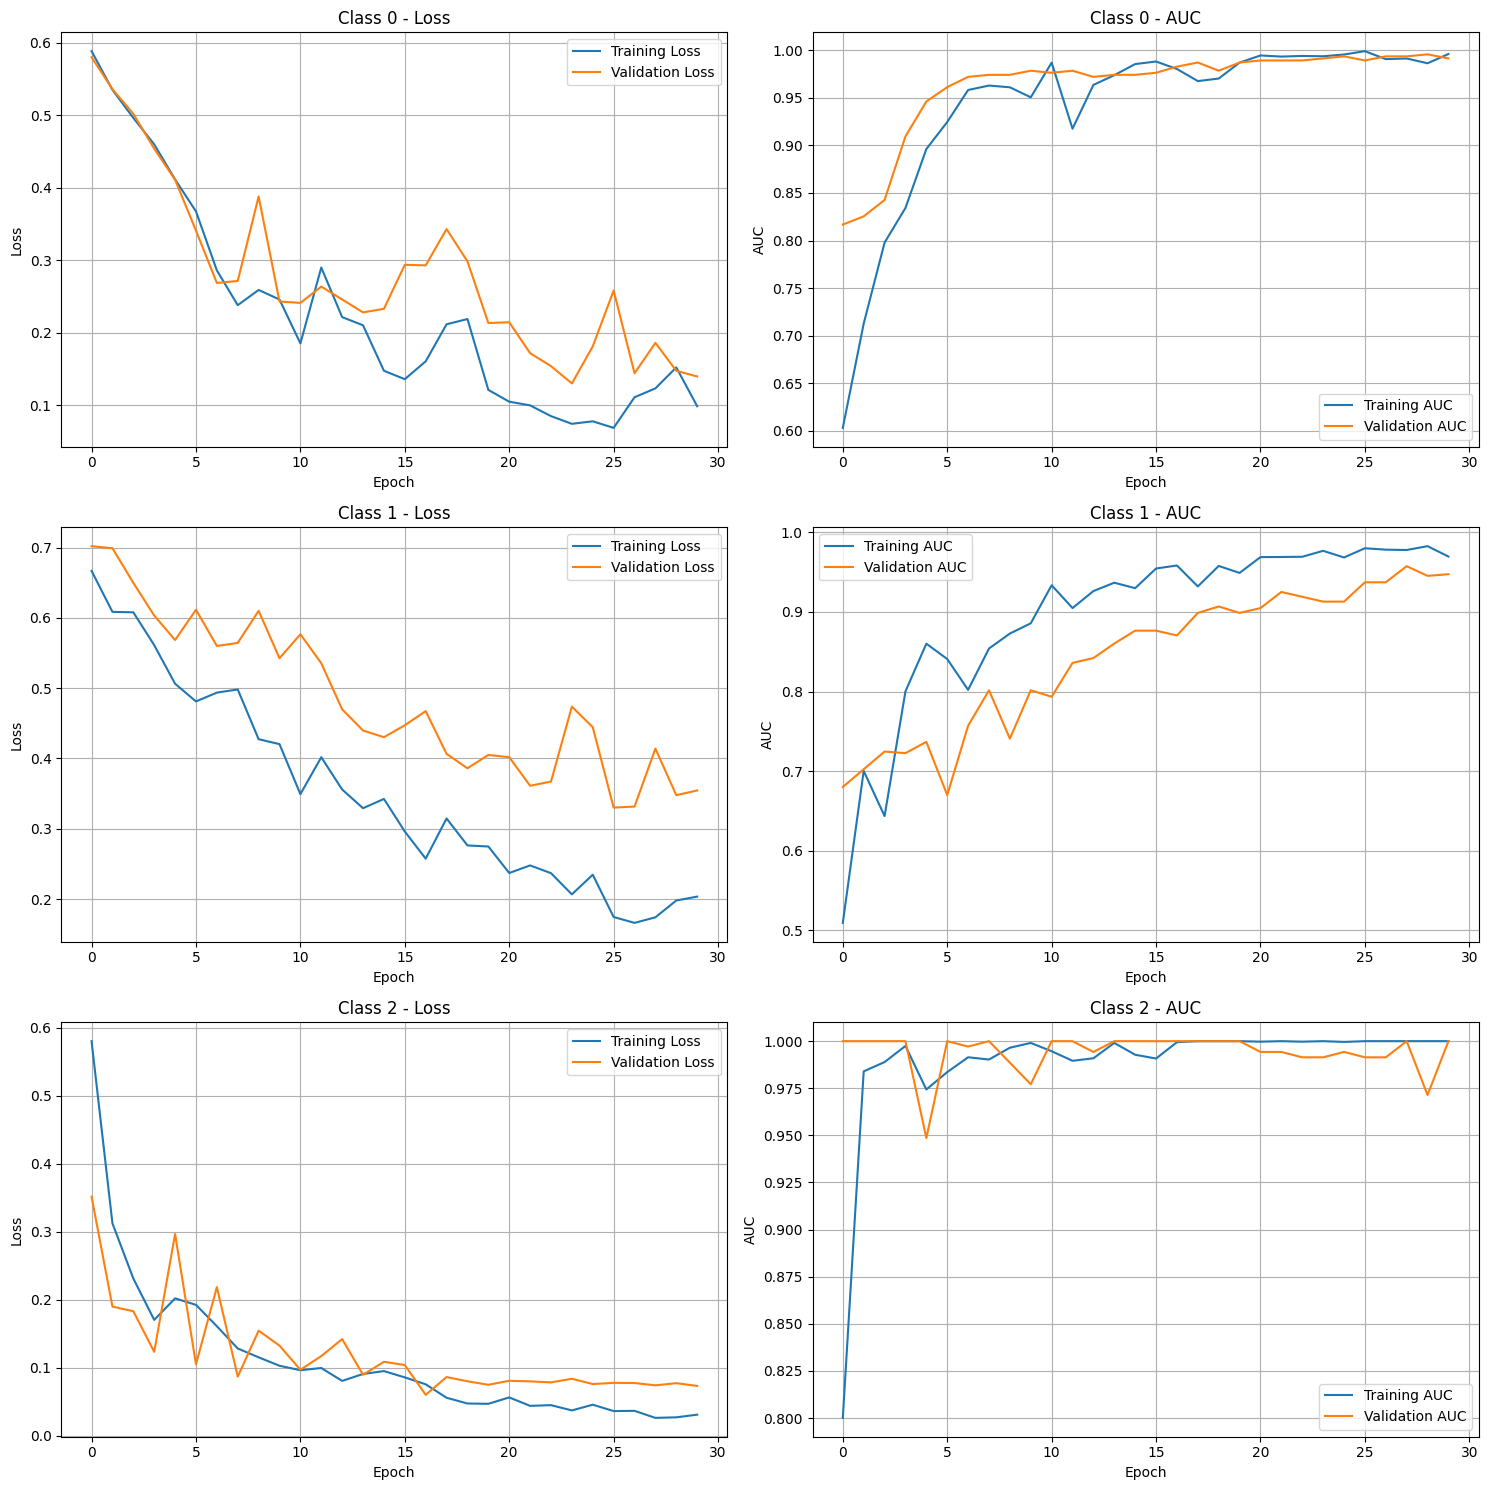

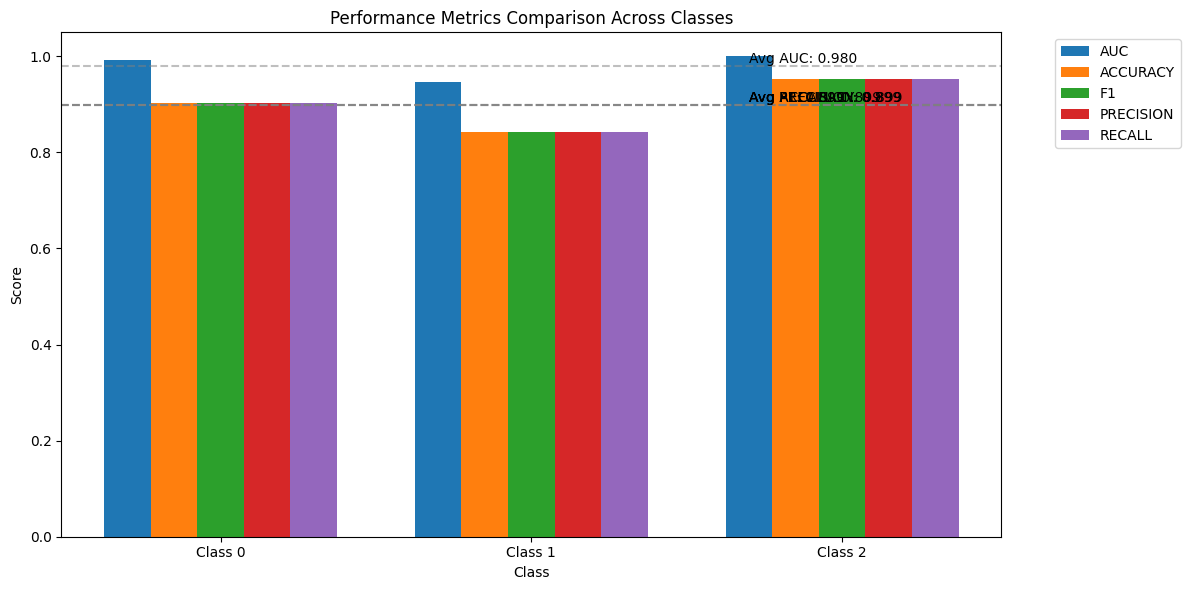

In [ ]:
# For binary classification:
trainer = PlaySenseTrainerV2(
    model=BinaryInertialMFCCTransformer,  # Note: pass the class, not an instance
    data_manager=data_manager,
    mode='binary',
    learning_rate=0.001,
    num_epochs=300,
    checkpoint_dir='binary_checkpoints'
)

# Train the model(s)
trainer.train(batch_size=32, train_ratio=0.8)

# Plot training history
trainer.plot_training_history()

## autoencoder


🚀 Training Autoencoder for label 0 (User 1)
------------------------------------------------------------
Dataset split for User 1:
  - Training target samples: 49
  - Validation target samples: 13
  - Validation non-target samples: 159
Epoch [1/500] - Train Loss: 1.7438 - Eval Loss: 1.4655
Epoch [2/500] - Train Loss: 1.4205 - Eval Loss: 1.3149
Epoch [3/500] - Train Loss: 1.2822 - Eval Loss: 1.2139
Epoch [4/500] - Train Loss: 1.1739 - Eval Loss: 1.1156
Epoch [5/500] - Train Loss: 1.0740 - Eval Loss: 1.0271
Epoch [6/500] - Train Loss: 0.9833 - Eval Loss: 0.9462
Epoch [7/500] - Train Loss: 0.8997 - Eval Loss: 0.8687
Epoch [8/500] - Train Loss: 0.8200 - Eval Loss: 0.7899
Epoch [9/500] - Train Loss: 0.7285 - Eval Loss: 0.7180
Epoch [10/500] - Train Loss: 0.6581 - Eval Loss: 0.6532
Epoch [11/500] - Train Loss: 0.5928 - Eval Loss: 0.5916
Epoch [12/500] - Train Loss: 0.5247 - Eval Loss: 0.5334
Epoch [13/500] - Train Loss: 0.4685 - Eval Loss: 0.4810
Epoch [14/500] - Train Loss: 0.4061 - Eval L

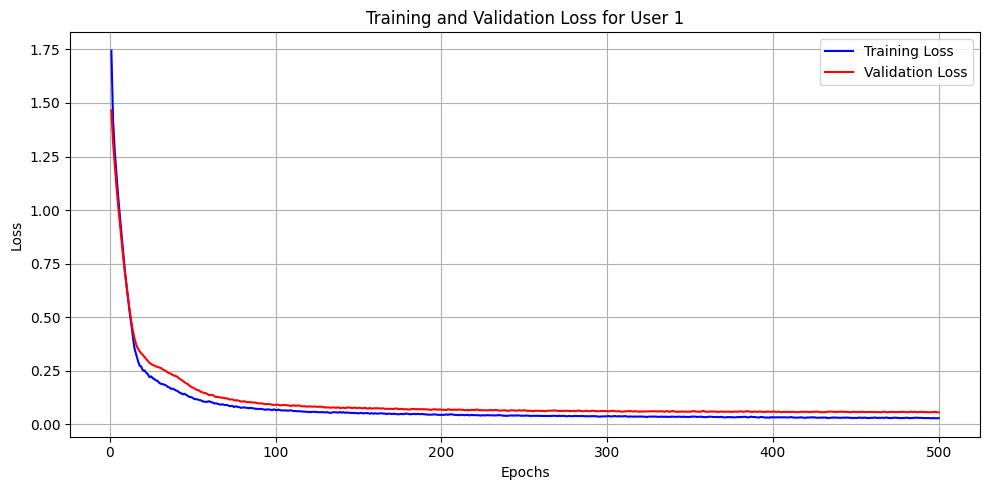


📊 Evaluation Results for Label 0:
  ✅ Accuracy: 0.8256
  ❌ FAR:      0.1258
  ❌ FRR:      0.1538
  ❗ EER:      0.1398


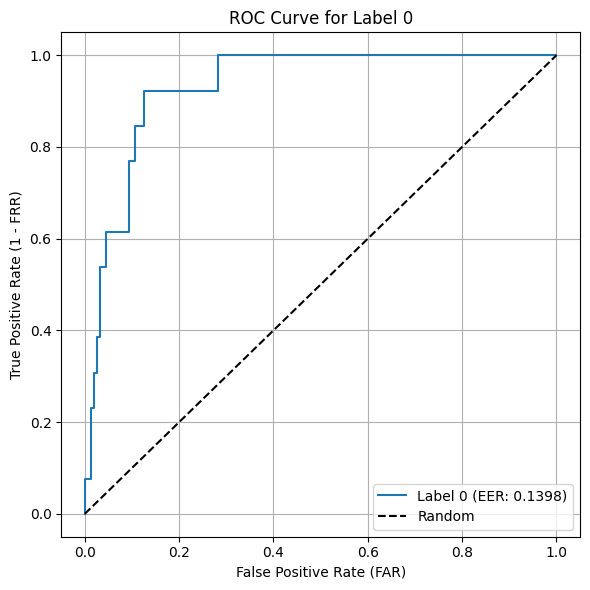


🚀 Training Autoencoder for label 1 (User 3)
------------------------------------------------------------
Dataset split for User 3:
  - Training target samples: 61
  - Validation target samples: 16
  - Validation non-target samples: 144
Epoch [1/500] - Train Loss: 1.6236 - Eval Loss: 1.3905
Epoch [2/500] - Train Loss: 1.3555 - Eval Loss: 1.2549
Epoch [3/500] - Train Loss: 1.2329 - Eval Loss: 1.1726
Epoch [4/500] - Train Loss: 1.1480 - Eval Loss: 1.0939
Epoch [5/500] - Train Loss: 1.0673 - Eval Loss: 1.0128
Epoch [6/500] - Train Loss: 0.9863 - Eval Loss: 0.9292
Epoch [7/500] - Train Loss: 0.9069 - Eval Loss: 0.8487
Epoch [8/500] - Train Loss: 0.8348 - Eval Loss: 0.7736
Epoch [9/500] - Train Loss: 0.7573 - Eval Loss: 0.7009
Epoch [10/500] - Train Loss: 0.6873 - Eval Loss: 0.6330
Epoch [11/500] - Train Loss: 0.6190 - Eval Loss: 0.5736
Epoch [12/500] - Train Loss: 0.5594 - Eval Loss: 0.5221
Epoch [13/500] - Train Loss: 0.5031 - Eval Loss: 0.4758
Epoch [14/500] - Train Loss: 0.4554 - Eval L

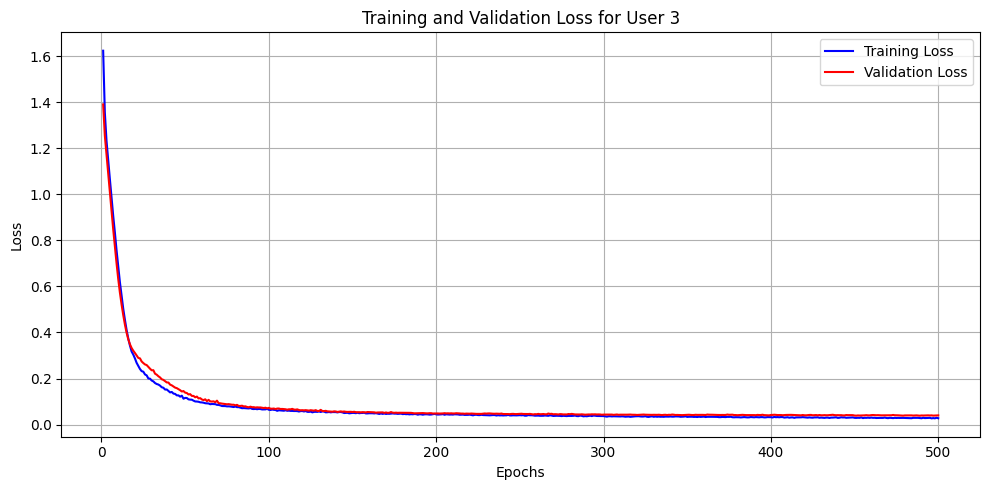


📊 Evaluation Results for Label 1:
  ✅ Accuracy: 0.5250
  ❌ FAR:      0.2500
  ❌ FRR:      0.1875
  ❗ EER:      0.2188


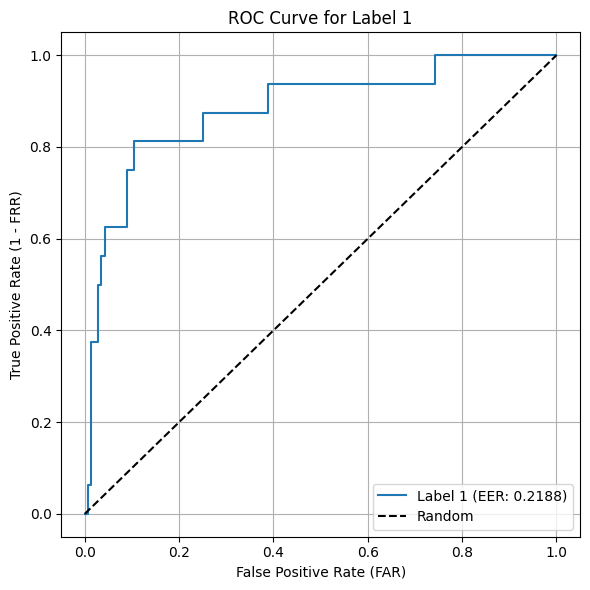


🚀 Training Autoencoder for label 2 (User 4)
------------------------------------------------------------
Dataset split for User 4:
  - Training target samples: 65
  - Validation target samples: 17
  - Validation non-target samples: 139
Epoch [1/500] - Train Loss: 1.7840 - Eval Loss: 1.5285
Epoch [2/500] - Train Loss: 1.4383 - Eval Loss: 1.3704
Epoch [3/500] - Train Loss: 1.2680 - Eval Loss: 1.2538
Epoch [4/500] - Train Loss: 1.1333 - Eval Loss: 1.1334
Epoch [5/500] - Train Loss: 0.9711 - Eval Loss: 1.0186
Epoch [6/500] - Train Loss: 0.8815 - Eval Loss: 0.9115
Epoch [7/500] - Train Loss: 0.8210 - Eval Loss: 0.8136
Epoch [8/500] - Train Loss: 0.7317 - Eval Loss: 0.7249
Epoch [9/500] - Train Loss: 0.6298 - Eval Loss: 0.6471
Epoch [10/500] - Train Loss: 0.5534 - Eval Loss: 0.5767
Epoch [11/500] - Train Loss: 0.4553 - Eval Loss: 0.5107
Epoch [12/500] - Train Loss: 0.4915 - Eval Loss: 0.4542
Epoch [13/500] - Train Loss: 0.4434 - Eval Loss: 0.4088
Epoch [14/500] - Train Loss: 0.3348 - Eval L

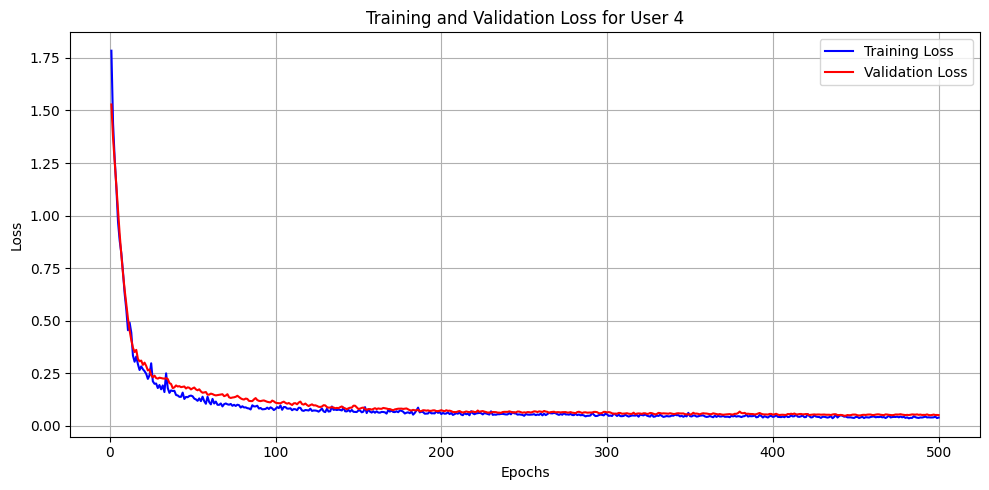


📊 Evaluation Results for Label 2:
  ✅ Accuracy: 0.6923
  ❌ FAR:      0.1942
  ❌ FRR:      0.1765
  ❗ EER:      0.1854


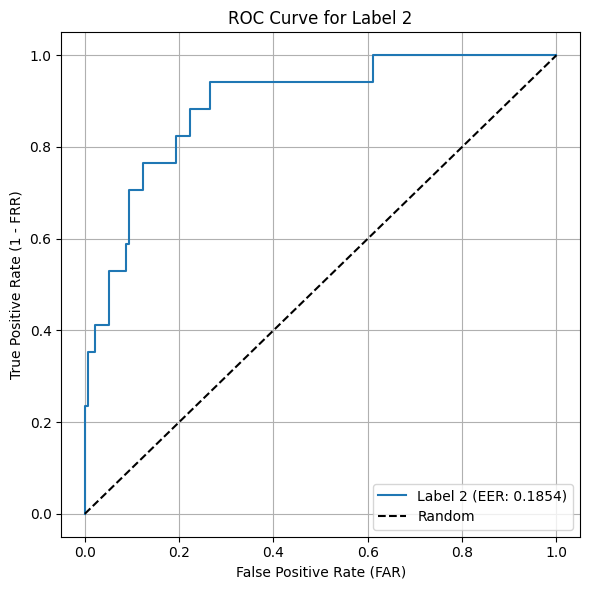


📊 AVERAGE METRICS ACROSS ALL USERS:
  ✅ Average Accuracy: 0.6810
  ❌ Average FAR:      0.1900
  ❌ Average FRR:      0.1726
  ❗ Average EER:      0.1813


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

dataset = data_manager.dataset
unique_labels = dataset.get_unique_classes()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_eer(fpr, tpr):
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    return eer

def normalize_batch(x):
    mean = x.mean(dim=(1, 2), keepdim=True)
    std = x.std(dim=(1, 2), keepdim=True) + 1e-6
    return (x - mean) / std

def train_one_class(label_id, num_epochs=50, batch_size=32, lr=1e-3, train_ratio=0.8):
    print(f"\n🚀 Training Autoencoder for label {label_id} (User {dataset.inverse_mapping[label_id]})\n{'-'*60}")

    target_indices = [i for i, l in enumerate(dataset.labels) if l == label_id]
    non_target_indices = [i for i, l in enumerate(dataset.labels) if l != label_id]

    # Split target indices into training and validation subsets
    train_target_indices, val_target_indices = train_test_split(
        target_indices, train_size=train_ratio, random_state=42
    )

    # Create datasets
    train_data = torch.utils.data.Subset(dataset, train_target_indices)
    val_target_data = torch.utils.data.Subset(dataset, val_target_indices)
    val_non_target_data = torch.utils.data.Subset(dataset, non_target_indices)

    # Print dataset sizes
    print(f"Dataset split for User {dataset.inverse_mapping[label_id]}:")
    print(f"  - Training target samples: {len(train_target_indices)}")
    print(f"  - Validation target samples: {len(val_target_indices)}")
    print(f"  - Validation non-target samples: {len(non_target_indices)}")

    # Combine target + non-target for validation
    val_data = torch.utils.data.ConcatDataset([val_target_data, val_non_target_data])

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = InertialMFCCTransformerAutoencoder(
        inertial_dim=12, mfcc_dim=13,
        d_model=64, nhead=4, num_layers=2
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    eval_loss_history = []

    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        total_loss = 0
        for batch in train_loader:
            inertial = normalize_batch(batch['inertial'].to(device))
            mfcc = normalize_batch(batch['mfcc'].to(device))

            optimizer.zero_grad()
            inertial_pred, mfcc_pred = model(inertial, mfcc)

            if inertial.shape[1] != inertial_pred.shape[1]:
                inertial = torch.nn.functional.interpolate(
                    inertial.transpose(1, 2),
                    size=inertial_pred.shape[1],
                    mode='linear',
                    align_corners=False
                ).transpose(1, 2)

            loss = criterion(inertial_pred, inertial) + criterion(mfcc_pred, mfcc)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # === Evaluation ===
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inertial = normalize_batch(batch['inertial'].to(device))
                mfcc = normalize_batch(batch['mfcc'].to(device))
                inertial_pred, mfcc_pred = model(inertial, mfcc)

                if inertial.shape[1] != inertial_pred.shape[1]:
                    inertial = torch.nn.functional.interpolate(
                        inertial.transpose(1, 2),
                        size=inertial_pred.shape[1],
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)

                loss = criterion(inertial_pred, inertial) + criterion(mfcc_pred, mfcc)
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_loader)
        eval_loss_history.append(avg_eval_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Eval Loss: {avg_eval_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
    plt.plot(epochs, eval_loss_history, 'r-', label='Validation Loss')
    plt.title(f'Training and Validation Loss for User {dataset.inverse_mapping[label_id]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Final Evaluation for Metrics ===
    def get_reconstruction_errors(loader):
        errors = []
        with torch.no_grad():
            for batch in loader:
                inertial = normalize_batch(batch['inertial'].to(device))
                mfcc = normalize_batch(batch['mfcc'].to(device))
                inertial_pred, mfcc_pred = model(inertial, mfcc)
                if inertial.shape[1] != inertial_pred.shape[1]:
                    inertial = torch.nn.functional.interpolate(
                        inertial.transpose(1, 2),
                        size=inertial_pred.shape[1],
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                loss = ((inertial_pred - inertial) ** 2).mean(dim=(1, 2)) + \
                       ((mfcc_pred - mfcc) ** 2).mean(dim=(1, 2))
                errors.extend(loss.cpu().numpy())
        return np.array(errors)

    target_errors = get_reconstruction_errors(
        torch.utils.data.DataLoader(val_target_data, batch_size=batch_size, shuffle=False)
    )
    non_target_errors = get_reconstruction_errors(
        torch.utils.data.DataLoader(val_non_target_data, batch_size=batch_size, shuffle=False)
    )

    threshold = np.percentile(target_errors, 95)
    y_true = np.concatenate([np.ones_like(target_errors), np.zeros_like(non_target_errors)])
    y_scores = np.concatenate([target_errors, non_target_errors])
    y_pred = (y_scores <= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, -y_scores)
    eer = compute_eer(fpr, tpr)
    far = fpr[np.argmin(np.abs(fpr - (1 - tpr)))]
    frr = 1 - tpr[np.argmin(np.abs(fpr - (1 - tpr)))]

    print(f"\n📊 Evaluation Results for Label {label_id}:")
    print(f"  ✅ Accuracy: {acc:.4f}")
    print(f"  ❌ FAR:      {far:.4f}")
    print(f"  ❌ FRR:      {frr:.4f}")
    print(f"  ❗ EER:      {eer:.4f}")

    # 📈 Plot ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'Label {label_id} (EER: {eer:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate (FAR)')
    plt.ylabel('True Positive Rate (1 - FRR)')
    plt.title(f'ROC Curve for Label {label_id}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, far, frr, eer, train_loss_history, eval_loss_history

# 🚀 Run training for each label
all_metrics = {
    'accuracy': [],
    'far': [],
    'frr': [],
    'eer': []
}

all_train_losses = {}
all_eval_losses = {}

for label in unique_labels:
    acc, far, frr, eer, train_loss_history, eval_loss_history = train_one_class(label, num_epochs=500)
    all_metrics['accuracy'].append(acc)
    all_metrics['far'].append(far)
    all_metrics['frr'].append(frr)
    all_metrics['eer'].append(eer)
    all_train_losses[label] = train_loss_history
    all_eval_losses[label] = eval_loss_history



# Calculate and display average metrics across all users
print("\n" + "="*60)
print("📊 AVERAGE METRICS ACROSS ALL USERS:")
print("="*60)
print(f"  ✅ Average Accuracy: {np.mean(all_metrics['accuracy']):.4f}")
print(f"  ❌ Average FAR:      {np.mean(all_metrics['far']):.4f}")
print(f"  ❌ Average FRR:      {np.mean(all_metrics['frr']):.4f}")
print(f"  ❗ Average EER:      {np.mean(all_metrics['eer']):.4f}")
print("="*60)
